In [1]:
!wget "http://opihi.cs.uvic.ca/sound/genres.tar.gz"

--2020-12-16 08:26:39--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  1009KB/s    in 19m 37s 

2020-12-16 08:46:17 (1017 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [3]:
#!tar -xvf genres.tar.gz

In [4]:
#importing required libraries
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
import pathlib
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [8]:
#header name for the csv file 
header = 'filename'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [9]:
#extracting mfcc features and writing into csv file
file = open('dataset.csv', 'w', newline='') 
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)  
        to_append = f'{filename}' 
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [10]:
#reading the csv file
data = pd.read_csv('dataset.csv')
data.head()

,filename,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00059.wav,-86.225308,91.948446,-23.408660,68.253294,-3.895874,22.745264,-9.899615,16.895979,-11.397530,18.431677,-7.015263,10.771055,-11.938686,1.005815,-5.923496,5.318166,-6.140526,1.948991,-5.102755,-0.666248,blues
1,blues.00024.wav,-274.288785,130.417424,-6.394800,70.410680,13.265857,9.463105,7.723189,-1.245347,-0.575020,-2.299992,3.783482,0.080915,-0.939682,2.295373,4.290512,-1.661926,-10.444825,-6.797826,-1.068164,-1.596130,blues
2,blues.00093.wav,-350.436204,169.545752,31.820372,16.682836,28.710147,19.256975,7.863395,10.036764,4.735106,2.907466,3.915553,1.821690,-5.970892,-5.259568,-0.229211,-1.776851,-3.713751,0.181590,2.072390,-2.896225,blues
3,blues.00056.wav,-145.434568,102.829023,-12.517677,56.993472,2.271347,26.591402,-4.274803,17.338809,-7.985593,15.235427,-6.934599,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues
4,blues.00071.wav,-89.357906,93.786055,-14.574538,54.391654,-33.508380,19.420994,-19.761601,13.026320,-13.865957,14.607766,-14.969526,10.585571,-18.026934,6.654247,-10.204747,6.527642,-10.846745,3.319423,-6.189024,2.994841,blues


In [11]:
#segregating the filename from the dataset
data = data.drop(['filename'],axis=1)

#encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

#scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [42]:
#splitting data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
print("Training X shape: ",X_train.shape)
print("Training Y shape: ",y_train.shape)

Training X shape:  (800, 20)
Training Y shape:  (800,)


In [44]:
print("Test X shape: ",X_test.shape)
print("Test Y shape: ",y_test.shape)

Test X shape:  (200, 20)
Test Y shape:  (200,)


In [45]:
#reshaping the input for LSTM model
X_train = X_train.reshape(800,20,1)
X_test = X_test.reshape(200,20,1)

In [46]:
#converting the labels to numerical ones
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [47]:
#building LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(10, activation='softmax'))

In [48]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 128)           66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 120,778
Trainable params: 120,778
Non-trainable params: 0
_________________________________________________________________


In [49]:
history=model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
13/13 [==============================] - 2s 119ms/step - loss: 2.2865 - accuracy: 0.1475 - val_loss: 2.2651 - val_accuracy: 0.1600
Epoch 2/30
13/13 [==============================] - 1s 55ms/step - loss: 2.2078 - accuracy: 0.1725 - val_loss: 2.1362 - val_accuracy: 0.1800
Epoch 3/30
13/13 [==============================] - 1s 55ms/step - loss: 2.0874 - accuracy: 0.2100 - val_loss: 2.0390 - val_accuracy: 0.2500
Epoch 4/30
13/13 [==============================] - 1s 54ms/step - loss: 2.0727 - accuracy: 0.2075 - val_loss: 2.0127 - val_accuracy: 0.2700
Epoch 5/30
13/13 [==============================] - 1s 54ms/step - loss: 2.0418 - accuracy: 0.2387 - val_loss: 2.0182 - val_accuracy: 0.2500
Epoch 6/30
13/13 [==============================] - 1s 56ms/step - loss: 2.0087 - accuracy: 0.2475 - val_loss: 2.0000 - val_accuracy: 0.2300
Epoch 7/30
13/13 [==============================] - 1s 55ms/step - loss: 2.0013 - accuracy: 0.2463 - val_loss: 1.9878 - val_accuracy: 0.2700
Epoch 8/30
1

In [50]:
 # evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

7/7 - 0s - loss: 1.7219 - accuracy: 0.4100

Test accuracy: 0.4099999964237213


Text(0.5, 1.0, 'Accuracy of the model')

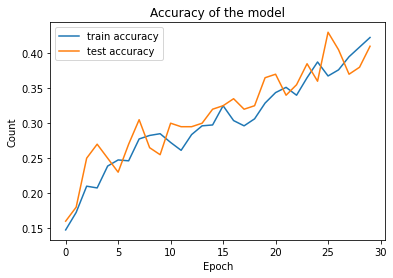

In [52]:
# create accuracy sublpot
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.legend(loc="upper left")
plt.title("Accuracy of the model")